In [1]:
import random
import numpy as np
import pandas as pd
import tqdm       
import copy
import itertools 
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ParameterGrid

# Unsupervised Learning models / Clustering
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Unsupervised Learning models / Clustering metrics
from sklearn.metrics import silhouette_score
from sklearn import metrics

# NLP
import tensorflow as tf
import nltk 
from string import punctuation
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # BoW, TFIDF
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
from keras.preprocessing.text import Tokenizer # Ovoj Tokenizer gi pretvara direktno vo unikatni broevi
from keras.utils import pad_sequences
eng_stopwords = stopwords.words("english")
import gensim.downloader as gen_downloader

from scipy.spatial.distance import cosine # cosine similarity
from unidecode import unidecode           # returns unicode characters (unicode transliteration)

#from keras.utils import np_utils         # one hot encoding vo VS Code
from keras.utils import to_categorical    # one hot encoding vo Colab

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

#
---
# FIRST DATASET: 'ingredient_w_synonyms.csv'

Cleaning the dataset

In [37]:
relative_path1 = '../Data/ingredient_w_synonyms.csv'
org_df = pd.read_csv(relative_path1, sep=';')
df = org_df.copy()

display(df)

name  \
0                                   Niacinamide   
1                               Hyaluronic Acid   
2                                Salicylic Acid   
3                                      Glycerin   
4                                       Retinol   
...                                         ...   
27638                         Dibutyldecyl Ipdi   
27639      Capsella Bursa-Pastoris Sprout Water   
27640                     Carboxyethyl Acrylate   
27641               Candelilla Wax Hydrocarbons   
27642  Ipomoea Hederacea Callus Culture Extract   

                                                 synonym  
0      Vitamin B3, Nicotinamide, and 3-Pyridinecarbox...  
1                                             Hyaluronan  
2                                                    NaN  
3            Vegetable Glycerin, Glycerine, and Glycerol  
4                                              Vitamin A  
...                                                  ...  
27638                                                NaN  
27639                                                NaN  
27640                                                NaN  
27641                                                NaN  
27642                                                NaN  

[27643 rows x 2 columns]

In [3]:
# duplicates_name = df[df['name'].duplicated()]
# duplicates_synonym = df[df['synonym'].duplicated()]
# display(duplicates_name)
# display(duplicates_synonym)


In [4]:
# df[df['name'].duplicated()]

In [5]:
# df = df.drop_duplicates(subset='name')
# df


In [6]:
# df.to_csv('Data/ingredient_w_synonyms_clean.csv')

In [7]:
# relative_path = '../Data/ingredients_nikola.csv'
# org_df_nikola = pd.read_csv(relative_path, sep=';')
# df_nikola = org_df_nikola.copy()

# display(df_nikola)

Importing clean dataset for further test preprocessing

In [8]:
relative_path2 = '../Data/ingredient_w_synonyms_clean.csv'
org_df = pd.read_csv(relative_path2)
df = org_df.copy()

display(df)

Unnamed: 0                                      name  \
0             142                          Cetearyl Alcohol   
1            1460                             Oleyl Alcohol   
2              19                               Ceramide AP   
3              60                            1,2-Hexanediol   
4             360                              Ceramide 1 A   
...           ...                                       ...   
27635       27638                         Dibutyldecyl Ipdi   
27636       27639      Capsella Bursa-Pastoris Sprout Water   
27637       27640                     Carboxyethyl Acrylate   
27638       27641               Candelilla Wax Hydrocarbons   
27639       27642  Ipomoea Hederacea Callus Culture Extract   

                                                 synonym  
0      (C16-C18) Alkyl Alcohol, C1618, C16-18 Alcohol...  
1                                     (Z)-Octadec-9-Enol  
2      1, 3, 4-Octadecanetriol, 2-(2-Hydroxy) Stearam...  
3                                         1,2 Hexanediol  
4                                  1,3,4-Octadecanetriol  
...                                                  ...  
27635                                                NaN  
27636                                                NaN  
27637                                                NaN  
27638                                                NaN  
27639                                                NaN  

[27640 rows x 3 columns]

In [9]:
df = df.drop(columns='Unnamed: 0')

In [10]:
df['all_possible_synonyms'] = df['name'] + ', ' + df['synonym']
df['all_possible_synonyms'].fillna(df['name'], inplace=True)
df

name  \
0                              Cetearyl Alcohol   
1                                 Oleyl Alcohol   
2                                   Ceramide AP   
3                                1,2-Hexanediol   
4                                  Ceramide 1 A   
...                                         ...   
27635                         Dibutyldecyl Ipdi   
27636      Capsella Bursa-Pastoris Sprout Water   
27637                     Carboxyethyl Acrylate   
27638               Candelilla Wax Hydrocarbons   
27639  Ipomoea Hederacea Callus Culture Extract   

                                                 synonym  \
0      (C16-C18) Alkyl Alcohol, C1618, C16-18 Alcohol...   
1                                     (Z)-Octadec-9-Enol   
2      1, 3, 4-Octadecanetriol, 2-(2-Hydroxy) Stearam...   
3                                         1,2 Hexanediol   
4                                  1,3,4-Octadecanetriol   
...                                                  ...   
27635                                                NaN   
27636                                                NaN   
27637                                                NaN   
27638                                                NaN   
27639                                                NaN   

                                   all_possible_synonyms  
0      Cetearyl Alcohol, (C16-C18) Alkyl Alcohol, C16...  
1                      Oleyl Alcohol, (Z)-Octadec-9-Enol  
2      Ceramide AP, 1, 3, 4-Octadecanetriol, 2-(2-Hyd...  
3                         1,2-Hexanediol, 1,2 Hexanediol  
4                    Ceramide 1 A, 1,3,4-Octadecanetriol  
...                                                  ...  
27635                                  Dibutyldecyl Ipdi  
27636               Capsella Bursa-Pastoris Sprout Water  
27637                              Carboxyethyl Acrylate  
27638                        Candelilla Wax Hydrocarbons  
27639           Ipomoea Hederacea Callus Culture Extract  

[27640 rows x 3 columns]

Funkcija sto gi dvoi so separator tocka stringovite od tipot: '1,2,3,4,4a,7,8,8a-Octahydro-2,4a,5,8a-Tetramethyl-Naphthyl Formate'

In [11]:
def format_number_string(df, column_name):
    # Check if the specified column exists in the DataFrame
    if column_name in df.columns:
        # # Apply the formatting to the specified column using regular expressions
        # df[column_name + '_formatted'] = df[column_name].apply(lambda x: re.sub(r'(\d),(?=\d)', r'\1.', str(x)))
        # df[column_name + '_formatted'] = df[column_name + '_formatted'].apply(lambda x: re.sub(r'(\d)a,(?=\d)', r'\1a.', str(x)))
        # df[column_name + '_formatted'] = df[column_name + '_formatted'].apply(lambda x: re.sub(r'(\d)a,(?=\d)', r'\1a.', str(x)))
        # df[column_name + '_formatted'] = df[column_name].apply(lambda x: re.sub(r'(\d+["("]?)(?:,)', r'\1.', str(x)))
        # #df[column_name + '_formatted'] = df[column_name + '_formatted'].apply(lambda x: re.sub(r'(\d)+"(",(?=\d)', r'\1+"(".', str(x)))         
        # df[column_name + '_formatted'] = df[column_name + '_formatted'].apply(lambda x: re.sub(r'(\d), (?=\d)', r'\1.', str(x)))
        # #df[column_name + '_formatted'] = df[column_name + '_formatted'].apply(lambda x: re.sub(r'(\d+[a]?)(?:, |,)', r'\1.', str(x)))  

        #df[column_name + '_formatted'] = df[column_name].apply(lambda x: re.sub(r'(\d+)([a]?)((?:, |,))', r'\1.', str(x)))

        df[column_name + '_formatted'] = df[column_name].apply(lambda x: re.sub(r'(\d+[a]?)(?:, |,)', r'\1.', str(x)))
        df[column_name + '_formatted'] = df[column_name].apply(lambda x: re.sub(r'(\d+["("]?)(?:,)', r'\1.', str(x)))
        #broj, bukva        
        return df
    else:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return None  # Return None if the specified column is not present

In [12]:
# Call the function to format the 'number,number' column
df_all_possible_synonyms_formatted = format_number_string(df, 'all_possible_synonyms')
df

name  \
0                              Cetearyl Alcohol   
1                                 Oleyl Alcohol   
2                                   Ceramide AP   
3                                1,2-Hexanediol   
4                                  Ceramide 1 A   
...                                         ...   
27635                         Dibutyldecyl Ipdi   
27636      Capsella Bursa-Pastoris Sprout Water   
27637                     Carboxyethyl Acrylate   
27638               Candelilla Wax Hydrocarbons   
27639  Ipomoea Hederacea Callus Culture Extract   

                                                 synonym  \
0      (C16-C18) Alkyl Alcohol, C1618, C16-18 Alcohol...   
1                                     (Z)-Octadec-9-Enol   
2      1, 3, 4-Octadecanetriol, 2-(2-Hydroxy) Stearam...   
3                                         1,2 Hexanediol   
4                                  1,3,4-Octadecanetriol   
...                                                  ...   
27635                                                NaN   
27636                                                NaN   
27637                                                NaN   
27638                                                NaN   
27639                                                NaN   

                                   all_possible_synonyms  \
0      Cetearyl Alcohol, (C16-C18) Alkyl Alcohol, C16...   
1                      Oleyl Alcohol, (Z)-Octadec-9-Enol   
2      Ceramide AP, 1, 3, 4-Octadecanetriol, 2-(2-Hyd...   
3                         1,2-Hexanediol, 1,2 Hexanediol   
4                    Ceramide 1 A, 1,3,4-Octadecanetriol   
...                                                  ...   
27635                                  Dibutyldecyl Ipdi   
27636               Capsella Bursa-Pastoris Sprout Water   
27637                              Carboxyethyl Acrylate   
27638                        Candelilla Wax Hydrocarbons   
27639           Ipomoea Hederacea Callus Culture Extract   

                         all_possible_synonyms_formatted  
0      Cetearyl Alcohol, (C16-C18) Alkyl Alcohol, C16...  
1                      Oleyl Alcohol, (Z)-Octadec-9-Enol  
2      Ceramide AP, 1. 3. 4-Octadecanetriol, 2-(2-Hyd...  
3                         1.2-Hexanediol, 1.2 Hexanediol  
4                    Ceramide 1 A, 1.3.4-Octadecanetriol  
...                                                  ...  
27635                                  Dibutyldecyl Ipdi  
27636               Capsella Bursa-Pastoris Sprout Water  
27637                              Carboxyethyl Acrylate  
27638                        Candelilla Wax Hydrocarbons  
27639           Ipomoea Hederacea Callus Culture Extract  

[27640 rows x 4 columns]

In [13]:
def is_sent_ok(toks: list, threshold: int) -> bool:
    if len(toks) >= threshold:
        return True
    return False

def clean_text(s):
    # Check if s is a string
    if isinstance(s, str):
        s = unidecode(s)  # è -> e (unicode transliteration)
        s = s.lower()

        #DA SE TRGNI STOPWORD end???? no problematicno e so se srekjava do zapirka ili pa voopsto nema zapirka, taka da ako se izbrisi moze dvata zbora da se spojat ako nema zapirka

        # s = s.translate(str.maketrans('', '', punctuation))
        # s = WordPunctTokenizer().tokenize(s)
        # s = [el for el in s if el not in eng_stopwords]  # Make sure 'eng_stopwords' is defined in your code
        return s
    else:
        return s  # Return the input unchanged if it's not a string
    
    if is_sent_ok(s, 3):
        return " ".join(s)
    return np.nan

Nekoi zabeleski za datasetot:
- Ne treba da se odzemaat stopwords, zatoa sto gi menuva primer Vitamin A, go krati na Vitamin
- Ne treba lematizacija, zatoa sto vekje se lematizirani!??
- Punktuacijata isto taka mislam deka e bitna I treba da ostani, imame soedinenija koi vo imeto imaat zapirka I crticka
- Imame brojki, niv ne treba da gi dekodirame, se buni funkcijata..
- Edinstven stopword sto ne ni treba e “and” vo listata so sinonimi gi nabrojuva oddeleni so zapirka I posledniot e so and dodaden (problematicno e sto se srekjava do zapirka ili pa voopsto nema zapirka, taka da ako se izbrisi moze dvata zbora da se spojat ako nema zapirka) - OVA GO SREDIV VO EXCEL SO FIND AND REPLACE!
- Ima lista so 540 sostojki sto se so brojki, crtki, zapirki, edinstveno pozitivno e sto se unique vo NASIOT dataset, t.e. samo dve od niv imaat sinonim



In [14]:
df = df.copy()
df['all_possible_synonyms_tok'] = df['all_possible_synonyms_formatted'].apply(clean_text)

Deleting all the rows from the dataset, that have long list of names in brackets:

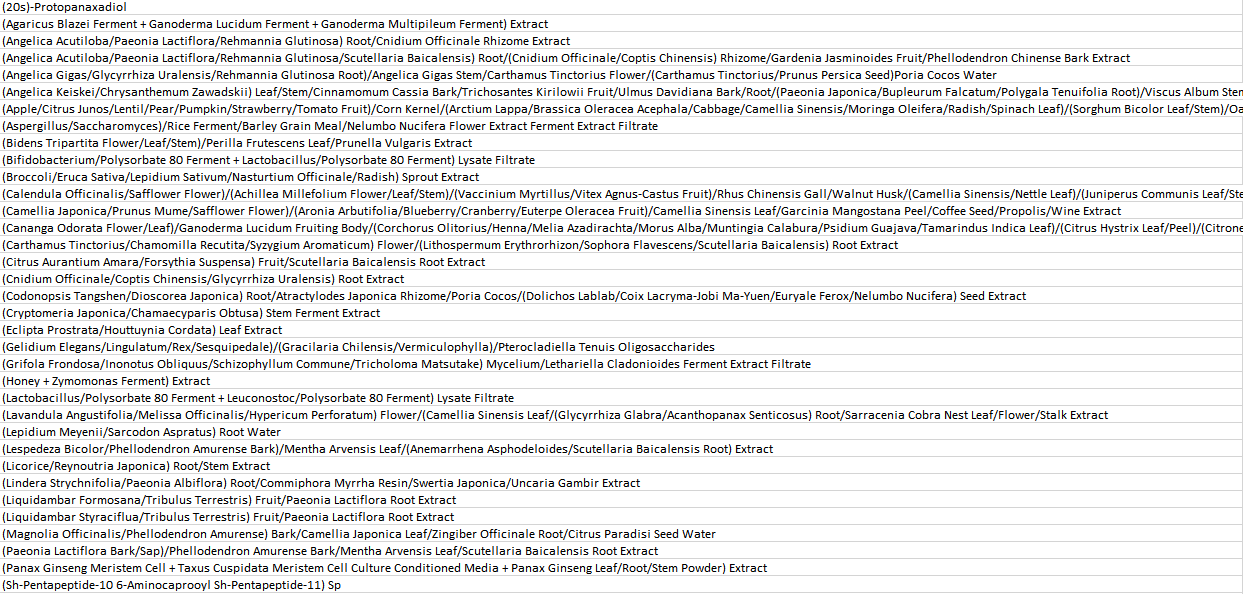

In [15]:
df = df[~df['name'].str.startswith('(')]
df = df[~df['name'].str.startswith('[')]
df

name  \
0                              Cetearyl Alcohol   
1                                 Oleyl Alcohol   
2                                   Ceramide AP   
3                                1,2-Hexanediol   
4                                  Ceramide 1 A   
...                                         ...   
27635                         Dibutyldecyl Ipdi   
27636      Capsella Bursa-Pastoris Sprout Water   
27637                     Carboxyethyl Acrylate   
27638               Candelilla Wax Hydrocarbons   
27639  Ipomoea Hederacea Callus Culture Extract   

                                                 synonym  \
0      (C16-C18) Alkyl Alcohol, C1618, C16-18 Alcohol...   
1                                     (Z)-Octadec-9-Enol   
2      1, 3, 4-Octadecanetriol, 2-(2-Hydroxy) Stearam...   
3                                         1,2 Hexanediol   
4                                  1,3,4-Octadecanetriol   
...                                                  ...   
27635                                                NaN   
27636                                                NaN   
27637                                                NaN   
27638                                                NaN   
27639                                                NaN   

                                   all_possible_synonyms  \
0      Cetearyl Alcohol, (C16-C18) Alkyl Alcohol, C16...   
1                      Oleyl Alcohol, (Z)-Octadec-9-Enol   
2      Ceramide AP, 1, 3, 4-Octadecanetriol, 2-(2-Hyd...   
3                         1,2-Hexanediol, 1,2 Hexanediol   
4                    Ceramide 1 A, 1,3,4-Octadecanetriol   
...                                                  ...   
27635                                  Dibutyldecyl Ipdi   
27636               Capsella Bursa-Pastoris Sprout Water   
27637                              Carboxyethyl Acrylate   
27638                        Candelilla Wax Hydrocarbons   
27639           Ipomoea Hederacea Callus Culture Extract   

                         all_possible_synonyms_formatted  \
0      Cetearyl Alcohol, (C16-C18) Alkyl Alcohol, C16...   
1                      Oleyl Alcohol, (Z)-Octadec-9-Enol   
2      Ceramide AP, 1. 3. 4-Octadecanetriol, 2-(2-Hyd...   
3                         1.2-Hexanediol, 1.2 Hexanediol   
4                    Ceramide 1 A, 1.3.4-Octadecanetriol   
...                                                  ...   
27635                                  Dibutyldecyl Ipdi   
27636               Capsella Bursa-Pastoris Sprout Water   
27637                              Carboxyethyl Acrylate   
27638                        Candelilla Wax Hydrocarbons   
27639           Ipomoea Hederacea Callus Culture Extract   

                               all_possible_synonyms_tok  
0      cetearyl alcohol, (c16-c18) alkyl alcohol, c16...  
1                      oleyl alcohol, (z)-octadec-9-enol  
2      ceramide ap, 1. 3. 4-octadecanetriol, 2-(2-hyd...  
3                         1.2-hexanediol, 1.2 hexanediol  
4                    ceramide 1 a, 1.3.4-octadecanetriol  
...                                                  ...  
27635                                  dibutyldecyl ipdi  
27636               capsella bursa-pastoris sprout water  
27637                              carboxyethyl acrylate  
27638                        candelilla wax hydrocarbons  
27639           ipomoea hederacea callus culture extract  

[27604 rows x 5 columns]

In [16]:
df['all_possible_synonyms'][0]

'Cetearyl Alcohol, (C16-C18) Alkyl Alcohol, C1618, C16-18 Alcohols, Cetostearyl Alcohol,Cetyl/Stearyl Alcohol'

In [17]:
df.to_csv('ingredient_w_synonyms_tokenized.csv')

In [18]:
df_ingredient = df[['name', 'all_possible_synonyms_tok']]
df_ingredient

name  \
0                              Cetearyl Alcohol   
1                                 Oleyl Alcohol   
2                                   Ceramide AP   
3                                1,2-Hexanediol   
4                                  Ceramide 1 A   
...                                         ...   
27635                         Dibutyldecyl Ipdi   
27636      Capsella Bursa-Pastoris Sprout Water   
27637                     Carboxyethyl Acrylate   
27638               Candelilla Wax Hydrocarbons   
27639  Ipomoea Hederacea Callus Culture Extract   

                               all_possible_synonyms_tok  
0      cetearyl alcohol, (c16-c18) alkyl alcohol, c16...  
1                      oleyl alcohol, (z)-octadec-9-enol  
2      ceramide ap, 1. 3. 4-octadecanetriol, 2-(2-hyd...  
3                         1.2-hexanediol, 1.2 hexanediol  
4                    ceramide 1 a, 1.3.4-octadecanetriol  
...                                                  ...  
27635                                  dibutyldecyl ipdi  
27636               capsella bursa-pastoris sprout water  
27637                              carboxyethyl acrylate  
27638                        candelilla wax hydrocarbons  
27639           ipomoea hederacea callus culture extract  

[27604 rows x 2 columns]

In [19]:
#df_ingredient['all_possible_synonyms_tok'] = df_ingredient['all_possible_synonyms_tok'].str.split(r', |,')
df_ingredient['all_possible_synonyms_tok'] = df_ingredient['all_possible_synonyms_tok'].str.split(r', |,(?![\d.])')
df_ingredient


C:\Users\Vesna\AppData\Local\Temp\ipykernel_8516\2877771138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ingredient['all_possible_synonyms_tok'] = df_ingredient['all_possible_synonyms_tok'].str.split(r', |,(?![\d.])')


name  \
0                              Cetearyl Alcohol   
1                                 Oleyl Alcohol   
2                                   Ceramide AP   
3                                1,2-Hexanediol   
4                                  Ceramide 1 A   
...                                         ...   
27635                         Dibutyldecyl Ipdi   
27636      Capsella Bursa-Pastoris Sprout Water   
27637                     Carboxyethyl Acrylate   
27638               Candelilla Wax Hydrocarbons   
27639  Ipomoea Hederacea Callus Culture Extract   

                               all_possible_synonyms_tok  
0      [cetearyl alcohol, (c16-c18) alkyl alcohol, c1...  
1                    [oleyl alcohol, (z)-octadec-9-enol]  
2      [ceramide ap, 1. 3. 4-octadecanetriol, 2-(2-hy...  
3                       [1.2-hexanediol, 1.2 hexanediol]  
4                  [ceramide 1 a, 1.3.4-octadecanetriol]  
...                                                  ...  
27635                                [dibutyldecyl ipdi]  
27636             [capsella bursa-pastoris sprout water]  
27637                            [carboxyethyl acrylate]  
27638                      [candelilla wax hydrocarbons]  
27639         [ipomoea hederacea callus culture extract]  

[27604 rows x 2 columns]

In [20]:
df_ingredient['all_possible_synonyms_tok'][0]

['cetearyl alcohol',
 '(c16-c18) alkyl alcohol',
 'c1618. c16-18 alcohols',
 'cetostearyl alcohol',
 'cetyl/stearyl alcohol']

In [21]:
df_ingredient_exploded = df_ingredient.explode('all_possible_synonyms_tok')
df_ingredient_exploded

name  \
0                              Cetearyl Alcohol   
0                              Cetearyl Alcohol   
0                              Cetearyl Alcohol   
0                              Cetearyl Alcohol   
0                              Cetearyl Alcohol   
...                                         ...   
27635                         Dibutyldecyl Ipdi   
27636      Capsella Bursa-Pastoris Sprout Water   
27637                     Carboxyethyl Acrylate   
27638               Candelilla Wax Hydrocarbons   
27639  Ipomoea Hederacea Callus Culture Extract   

                      all_possible_synonyms_tok  
0                              cetearyl alcohol  
0                       (c16-c18) alkyl alcohol  
0                        c1618. c16-18 alcohols  
0                           cetostearyl alcohol  
0                         cetyl/stearyl alcohol  
...                                         ...  
27635                         dibutyldecyl ipdi  
27636      capsella bursa-pastoris sprout water  
27637                     carboxyethyl acrylate  
27638               candelilla wax hydrocarbons  
27639  ipomoea hederacea callus culture extract  

[28801 rows x 2 columns]

In [22]:
df_ingredient_exploded.to_csv('ingredient_list.csv')

#
---
# SECOND DATASET '_Product__RAW_Data.xlsx'

In [23]:

relative_path3 = '../Data/_Product__RAW_Data.xlsx'
org_df_barcode = pd.read_excel(relative_path3)
df_barcode = org_df_barcode.copy()

display(df_barcode)

Barcode     Unnamed: 1  \
0      3600542399326  3600542399326   
1      8606029266766  8606029266766   
2      4049639429550  4049639429550   
3      4011700740291  4011700740291   
4      4011700740475  4011700740475   
...              ...            ...   
13670  6001051004959  6001051004959   
13671  5060447940494  5060447940494   
13672  4005900870407  4005900870407   
13673  8436575091013  8436575091013   
13674  8436575091013  8436575091013   

                                         Ingredient List  \
0      Aqua / Water, Aluminum Chlorohydrate, Cetearyl...   
1                                               Silicone   
2      aqua (water),stearic acid,copernicia cerifera ...   
3      butane,alcohol,propane,parfum (fragrance),dipr...   
4      sodium palmate,sodium palm kernelate,aqua (wat...   
...                                                  ...   
13670  Aqua, Alcohol Denat., Butyl Methoxydibenzoylme...   
13671  Aqua (Water), Octocrylene, Alcohol Denat., Gly...   
13672  ALPHA-ISOMETHYL IONONE, *******, BUTYL METHOXY...   
13673  AQUA (WATER), CUCUMIS SATIVUS (CUCUMBER）FRUIT ...   
13674  2-Ethyl-3,(5 Or 6)-Dimethylpyrazine, 2-Trans, ...   

                                                    Name  
0      Garnier Mineral Hyaluronic Care 72H Deodorant ...  
1                            Velnea Fingering Silik.Lila  
2      Magic Finish 5-In-1 Hybrid Mascara\nVolume, Le...  
3      Echt Kï¿½Lnisch Wasser Aerosol Deodorant Spray...  
4      Echt Kï¿½Lnisch Wasser Cream Soap\nMildly Clea...  
...                                                  ...  
13670          Sun Babies & Kids Kids' Sun Spray Spf 50+  
13671                                   Sun Cream Spf 30  
13672                Sun Oil Spray Tropical Bronze Spf 6  
13673                                      Retinol Cream  
13674                                                NaN  

[13675 rows x 4 columns]

In [24]:
columns_are_equal = (df_barcode['Barcode'] == df_barcode['Unnamed: 1']).all()

# Print the result
if columns_are_equal:
    print("All values in 'Column1' and 'Column2' are equal.")
else:
    print("Not all values in 'Column1' and 'Column2' are equal.") 



All values in 'Column1' and 'Column2' are equal.


In [25]:
# Se brisi ednata kolona bidejki e identicna so prvata
df_barcode = df_barcode.drop(columns='Unnamed: 1')

In [26]:
df_barcode.rename(columns={'Ingredient List': 'ingredient_list'}, inplace=True)
df_barcode.rename(columns={'Name': 'product_name'}, inplace=True)
df_barcode

Barcode                                    ingredient_list  \
0      3600542399326  Aqua / Water, Aluminum Chlorohydrate, Cetearyl...   
1      8606029266766                                           Silicone   
2      4049639429550  aqua (water),stearic acid,copernicia cerifera ...   
3      4011700740291  butane,alcohol,propane,parfum (fragrance),dipr...   
4      4011700740475  sodium palmate,sodium palm kernelate,aqua (wat...   
...              ...                                                ...   
13670  6001051004959  Aqua, Alcohol Denat., Butyl Methoxydibenzoylme...   
13671  5060447940494  Aqua (Water), Octocrylene, Alcohol Denat., Gly...   
13672  4005900870407  ALPHA-ISOMETHYL IONONE, *******, BUTYL METHOXY...   
13673  8436575091013  AQUA (WATER), CUCUMIS SATIVUS (CUCUMBER）FRUIT ...   
13674  8436575091013  2-Ethyl-3,(5 Or 6)-Dimethylpyrazine, 2-Trans, ...   

                                            product_name  
0      Garnier Mineral Hyaluronic Care 72H Deodorant ...  
1                            Velnea Fingering Silik.Lila  
2      Magic Finish 5-In-1 Hybrid Mascara\nVolume, Le...  
3      Echt Kï¿½Lnisch Wasser Aerosol Deodorant Spray...  
4      Echt Kï¿½Lnisch Wasser Cream Soap\nMildly Clea...  
...                                                  ...  
13670          Sun Babies & Kids Kids' Sun Spray Spf 50+  
13671                                   Sun Cream Spf 30  
13672                Sun Oil Spray Tropical Bronze Spf 6  
13673                                      Retinol Cream  
13674                                                NaN  

[13675 rows x 3 columns]

In [27]:
# Call the function to format the 'number,number' column
df_barcode_formatted = format_number_string(df_barcode, 'ingredient_list')

# !!!! Kolona za testiranje samo, dodadena e vo datasetot fiktivno, treba da se izbrise na kraj !!!!
display(df_barcode.iloc[-1]['ingredient_list'])
display(df_barcode.iloc[-1]['ingredient_list_formatted'])

'2-Ethyl-3,(5 Or 6)-Dimethylpyrazine, 2-Trans, 6-Cis-Nonadienol, C1618, C16-18 Alcohols, 1, 3, 4-Octadecanetriol, 6,10-Dimethylundeca-1,5,9-Trien-4-Ol, 6-Amino-M-Cresol, 6,7-Dihydrolinalool, 6-Hydroxyindole, 1,2,3,4,4a,7,8,8a-Octahydro-2,4a,5,8a-Tetramethyl-Naphthyl Formate'

'2-Ethyl-3.(5 Or 6)-Dimethylpyrazine, 2-Trans, 6-Cis-Nonadienol, C1618. C16-18 Alcohols, 1. 3. 4-Octadecanetriol, 6.10-Dimethylundeca-1.5.9-Trien-4-Ol, 6-Amino-M-Cresol, 6.7-Dihydrolinalool, 6-Hydroxyindole, 1.2.3.4.4a,7.8.8a-Octahydro-2.4a,5.8a-Tetramethyl-Naphthyl Formate'

In [28]:
df_barcode['ingredient_list_tok'] = df_barcode['ingredient_list_formatted'].apply(clean_text)
df_barcode

Barcode                                    ingredient_list  \
0      3600542399326  Aqua / Water, Aluminum Chlorohydrate, Cetearyl...   
1      8606029266766                                           Silicone   
2      4049639429550  aqua (water),stearic acid,copernicia cerifera ...   
3      4011700740291  butane,alcohol,propane,parfum (fragrance),dipr...   
4      4011700740475  sodium palmate,sodium palm kernelate,aqua (wat...   
...              ...                                                ...   
13670  6001051004959  Aqua, Alcohol Denat., Butyl Methoxydibenzoylme...   
13671  5060447940494  Aqua (Water), Octocrylene, Alcohol Denat., Gly...   
13672  4005900870407  ALPHA-ISOMETHYL IONONE, *******, BUTYL METHOXY...   
13673  8436575091013  AQUA (WATER), CUCUMIS SATIVUS (CUCUMBER）FRUIT ...   
13674  8436575091013  2-Ethyl-3,(5 Or 6)-Dimethylpyrazine, 2-Trans, ...   

                                            product_name  \
0      Garnier Mineral Hyaluronic Care 72H Deodorant ...   
1                            Velnea Fingering Silik.Lila   
2      Magic Finish 5-In-1 Hybrid Mascara\nVolume, Le...   
3      Echt Kï¿½Lnisch Wasser Aerosol Deodorant Spray...   
4      Echt Kï¿½Lnisch Wasser Cream Soap\nMildly Clea...   
...                                                  ...   
13670          Sun Babies & Kids Kids' Sun Spray Spf 50+   
13671                                   Sun Cream Spf 30   
13672                Sun Oil Spray Tropical Bronze Spf 6   
13673                                      Retinol Cream   
13674                                                NaN   

                               ingredient_list_formatted  \
0      Aqua / Water, Aluminum Chlorohydrate, Cetearyl...   
1                                               Silicone   
2      aqua (water),stearic acid,copernicia cerifera ...   
3      butane,alcohol,propane,parfum (fragrance),dipr...   
4      sodium palmate,sodium palm kernelate,aqua (wat...   
...                                                  ...   
13670  Aqua, Alcohol Denat., Butyl Methoxydibenzoylme...   
13671  Aqua (Water), Octocrylene, Alcohol Denat., Gly...   
13672  ALPHA-ISOMETHYL IONONE, *******, BUTYL METHOXY...   
13673  AQUA (WATER), CUCUMIS SATIVUS (CUCUMBER）FRUIT ...   
13674  2-Ethyl-3.(5 Or 6)-Dimethylpyrazine, 2-Trans, ...   

                                     ingredient_list_tok  
0      aqua / water, aluminum chlorohydrate, cetearyl...  
1                                               silicone  
2      aqua (water),stearic acid,copernicia cerifera ...  
3      butane,alcohol,propane,parfum (fragrance),dipr...  
4      sodium palmate,sodium palm kernelate,aqua (wat...  
...                                                  ...  
13670  aqua, alcohol denat., butyl methoxydibenzoylme...  
13671  aqua (water), octocrylene, alcohol denat., gly...  
13672  alpha-isomethyl ionone, *******, butyl methoxy...  
13673  aqua (water), cucumis sativus (cucumber)fruit ...  
13674  2-ethyl-3.(5 or 6)-dimethylpyrazine, 2-trans, ...  

[13675 rows x 5 columns]

In [29]:
# df_barcode.to_excel('_Product__RAW_Data_tokenized.xlsx')

---
# Making short list for testing: MATCHING THE INGREDIENTS

In [30]:
relative_path4 = '../Data/_Product__RAW_Data_Short.xlsx'
org_df_barcode_short = pd.read_excel(relative_path4)
df_barcode_short = org_df_barcode_short.copy()

display(df_barcode_short)

Barcode     Unnamed: 1  \
0   3600542399326  3600542399326   
1   8606029266766  8606029266766   
2   4049639429550  4049639429550   
3   4011700740291  4011700740291   
4   4011700740475  4011700740475   
..            ...            ...   
94  2200262607476  2200262607476   
95  2200251560652  2200251560652   
96  2200266790686  2200266790686   
97  2200244512156  2200244512156   
98  2200254749788  2200254749788   

                                      Ingredient List  \
0   Aqua / Water, Aluminum Chlorohydrate, Cetearyl...   
1                                            Silicone   
2   aqua (water),stearic acid,copernicia cerifera ...   
3   butane,alcohol,propane,parfum (fragrance),dipr...   
4   sodium palmate,sodium palm kernelate,aqua (wat...   
..                                                ...   
94  butane,propane,ethylhexyl stearate,isobutane,c...   
95  aqua (water),cetearyl alcohol,dicaprylyl ether...   
96  ethylhexyl stearate,ricinus communis (castor) ...   
97  aqua (water),isopropyl myristate,glyceryl stea...   
98  maris sal,parfum (fragrance),sodium methyl ole...   

                                                 Name  
0   Garnier Mineral Hyaluronic Care 72H Deodorant ...  
1                         Velnea Fingering Silik.Lila  
2   Magic Finish 5-In-1 Hybrid Mascara\nVolume, Le...  
3   Echt Kï¿½Lnisch Wasser Aerosol Deodorant Spray...  
4   Echt Kï¿½Lnisch Wasser Cream Soap\nMildly Clea...  
..                                                ...  
94  Deospray Sensitive & Care 48H\nGentle On Sensi...  
95  Fabulously Long Professional Conditioner\nSpec...  
96  Fascinating Rosï¿½ Lip Balm\nWith Shea Butter ...  
97  Flower Magic Roll-On Deodorant\nReliably Protects  
98  "For My Love" Bath Salts\nBathing Pleasure Wit...  

[99 rows x 4 columns]

In [31]:
df_barcode_short = df_barcode_short.drop(columns='Unnamed: 1')
df_barcode_short.rename(columns={'Ingredient List': 'ingredient_list'}, inplace=True)
df_barcode_short.rename(columns={'Name': 'product_name'}, inplace=True)
df_barcode_short_formatted = format_number_string(df_barcode_short, 'ingredient_list')
df_barcode_short['ingredient'] = df_barcode_short['ingredient_list_formatted'].apply(clean_text)
df_barcode_short

Barcode                                    ingredient_list  \
0   3600542399326  Aqua / Water, Aluminum Chlorohydrate, Cetearyl...   
1   8606029266766                                           Silicone   
2   4049639429550  aqua (water),stearic acid,copernicia cerifera ...   
3   4011700740291  butane,alcohol,propane,parfum (fragrance),dipr...   
4   4011700740475  sodium palmate,sodium palm kernelate,aqua (wat...   
..            ...                                                ...   
94  2200262607476  butane,propane,ethylhexyl stearate,isobutane,c...   
95  2200251560652  aqua (water),cetearyl alcohol,dicaprylyl ether...   
96  2200266790686  ethylhexyl stearate,ricinus communis (castor) ...   
97  2200244512156  aqua (water),isopropyl myristate,glyceryl stea...   
98  2200254749788  maris sal,parfum (fragrance),sodium methyl ole...   

                                         product_name  \
0   Garnier Mineral Hyaluronic Care 72H Deodorant ...   
1                         Velnea Fingering Silik.Lila   
2   Magic Finish 5-In-1 Hybrid Mascara\nVolume, Le...   
3   Echt Kï¿½Lnisch Wasser Aerosol Deodorant Spray...   
4   Echt Kï¿½Lnisch Wasser Cream Soap\nMildly Clea...   
..                                                ...   
94  Deospray Sensitive & Care 48H\nGentle On Sensi...   
95  Fabulously Long Professional Conditioner\nSpec...   
96  Fascinating Rosï¿½ Lip Balm\nWith Shea Butter ...   
97  Flower Magic Roll-On Deodorant\nReliably Protects   
98  "For My Love" Bath Salts\nBathing Pleasure Wit...   

                            ingredient_list_formatted  \
0   Aqua / Water, Aluminum Chlorohydrate, Cetearyl...   
1                                            Silicone   
2   aqua (water),stearic acid,copernicia cerifera ...   
3   butane,alcohol,propane,parfum (fragrance),dipr...   
4   sodium palmate,sodium palm kernelate,aqua (wat...   
..                                                ...   
94  butane,propane,ethylhexyl stearate,isobutane,c...   
95  aqua (water),cetearyl alcohol,dicaprylyl ether...   
96  ethylhexyl stearate,ricinus communis (castor) ...   
97  aqua (water),isopropyl myristate,glyceryl stea...   
98  maris sal,parfum (fragrance),sodium methyl ole...   

                                           ingredient  
0   aqua / water, aluminum chlorohydrate, cetearyl...  
1                                            silicone  
2   aqua (water),stearic acid,copernicia cerifera ...  
3   butane,alcohol,propane,parfum (fragrance),dipr...  
4   sodium palmate,sodium palm kernelate,aqua (wat...  
..                                                ...  
94  butane,propane,ethylhexyl stearate,isobutane,c...  
95  aqua (water),cetearyl alcohol,dicaprylyl ether...  
96  ethylhexyl stearate,ricinus communis (castor) ...  
97  aqua (water),isopropyl myristate,glyceryl stea...  
98  maris sal,parfum (fragrance),sodium methyl ole...  

[99 rows x 5 columns]

In [32]:
df_barcode_short['ingredient_list'][0]

'Aqua / Water, Aluminum Chlorohydrate, Cetearyl Alcohol, Ceteareth-33, Parfum / Fragrance, Sodium Hyaluronate, Perlite, Pentylene Glycol, Dimethicone, Phenoxyethanol.'

In [33]:
df_barcode_short = df_barcode_short[['Barcode', 'product_name', 'ingredient']]
df_barcode_short

Barcode                                       product_name  \
0   3600542399326  Garnier Mineral Hyaluronic Care 72H Deodorant ...   
1   8606029266766                        Velnea Fingering Silik.Lila   
2   4049639429550  Magic Finish 5-In-1 Hybrid Mascara\nVolume, Le...   
3   4011700740291  Echt Kï¿½Lnisch Wasser Aerosol Deodorant Spray...   
4   4011700740475  Echt Kï¿½Lnisch Wasser Cream Soap\nMildly Clea...   
..            ...                                                ...   
94  2200262607476  Deospray Sensitive & Care 48H\nGentle On Sensi...   
95  2200251560652  Fabulously Long Professional Conditioner\nSpec...   
96  2200266790686  Fascinating Rosï¿½ Lip Balm\nWith Shea Butter ...   
97  2200244512156  Flower Magic Roll-On Deodorant\nReliably Protects   
98  2200254749788  "For My Love" Bath Salts\nBathing Pleasure Wit...   

                                           ingredient  
0   aqua / water, aluminum chlorohydrate, cetearyl...  
1                                            silicone  
2   aqua (water),stearic acid,copernicia cerifera ...  
3   butane,alcohol,propane,parfum (fragrance),dipr...  
4   sodium palmate,sodium palm kernelate,aqua (wat...  
..                                                ...  
94  butane,propane,ethylhexyl stearate,isobutane,c...  
95  aqua (water),cetearyl alcohol,dicaprylyl ether...  
96  ethylhexyl stearate,ricinus communis (castor) ...  
97  aqua (water),isopropyl myristate,glyceryl stea...  
98  maris sal,parfum (fragrance),sodium methyl ole...  

[99 rows x 3 columns]

In [34]:
df_barcode_short['ingredient'] = df_barcode_short['ingredient'].str.split(r', |,(?![\d.])')
df_barcode_short

C:\Users\Vesna\AppData\Local\Temp\ipykernel_8516\647228050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barcode_short['ingredient'] = df_barcode_short['ingredient'].str.split(r', |,(?![\d.])')


Barcode                                       product_name  \
0   3600542399326  Garnier Mineral Hyaluronic Care 72H Deodorant ...   
1   8606029266766                        Velnea Fingering Silik.Lila   
2   4049639429550  Magic Finish 5-In-1 Hybrid Mascara\nVolume, Le...   
3   4011700740291  Echt Kï¿½Lnisch Wasser Aerosol Deodorant Spray...   
4   4011700740475  Echt Kï¿½Lnisch Wasser Cream Soap\nMildly Clea...   
..            ...                                                ...   
94  2200262607476  Deospray Sensitive & Care 48H\nGentle On Sensi...   
95  2200251560652  Fabulously Long Professional Conditioner\nSpec...   
96  2200266790686  Fascinating Rosï¿½ Lip Balm\nWith Shea Butter ...   
97  2200244512156  Flower Magic Roll-On Deodorant\nReliably Protects   
98  2200254749788  "For My Love" Bath Salts\nBathing Pleasure Wit...   

                                           ingredient  
0   [aqua / water, aluminum chlorohydrate, ceteary...  
1                                          [silicone]  
2   [aqua (water), stearic acid, copernicia cerife...  
3   [butane, alcohol, propane, parfum (fragrance),...  
4   [sodium palmate, sodium palm kernelate, aqua (...  
..                                                ...  
94  [butane, propane, ethylhexyl stearate, isobuta...  
95  [aqua (water), cetearyl alcohol, dicaprylyl et...  
96  [ethylhexyl stearate, ricinus communis (castor...  
97  [aqua (water), isopropyl myristate, glyceryl s...  
98  [maris sal, parfum (fragrance), sodium methyl ...  

[99 rows x 3 columns]

In [35]:
df_barcode_short_exploded = df_barcode_short.explode('ingredient')
df_barcode_short_exploded

Barcode                                       product_name  \
0   3600542399326  Garnier Mineral Hyaluronic Care 72H Deodorant ...   
0   3600542399326  Garnier Mineral Hyaluronic Care 72H Deodorant ...   
0   3600542399326  Garnier Mineral Hyaluronic Care 72H Deodorant ...   
0   3600542399326  Garnier Mineral Hyaluronic Care 72H Deodorant ...   
0   3600542399326  Garnier Mineral Hyaluronic Care 72H Deodorant ...   
..            ...                                                ...   
98  2200254749788  "For My Love" Bath Salts\nBathing Pleasure Wit...   
98  2200254749788  "For My Love" Bath Salts\nBathing Pleasure Wit...   
98  2200254749788  "For My Love" Bath Salts\nBathing Pleasure Wit...   
98  2200254749788  "For My Love" Bath Salts\nBathing Pleasure Wit...   
98  2200254749788  "For My Love" Bath Salts\nBathing Pleasure Wit...   

                          ingredient  
0                       aqua / water  
0             aluminum chlorohydrate  
0                   cetearyl alcohol  
0   ceteareth-33. parfum / fragrance  
0                 sodium hyaluronate  
..                               ...  
98                           alcohol  
98                      aqua (water)  
98               ci 15985 (yellow 6)  
98          ci 47005.sodium chloride  
98                    sodium sulfate  

[1618 rows x 3 columns]

In [36]:
df_barcode_short_exploded.to_csv('product_list_short.csv')